# GWAS in the cloud
We adapted the NIH CFDE tutorial from [here](https://training.nih-cfde.org/en/latest/Bioinformatic-Analyses/GWAS-in-the-cloud/background/) and fit it to a notebook. We have greatly simplified the instructions, so if you need or want more details, look at the full tutorial to find out more.
Most of this notebook is bash, but expects that you are using a Python kernel, until step 3, plotting, you will need to switch your kernel to R.

## 1. Setup
### Download the data
use %%bash to denote a bash block. You can also use '!' to denote a single bash command within a Python notebook

In [1]:
%%bash
mkdir GWAS
curl -LO https://de.cyverse.org/dl/d/E0A502CC-F806-4857-9C3A-BAEAA0CCC694/pruned_coatColor_maf_geno.vcf.gz
curl -LO https://de.cyverse.org/dl/d/3B5C1853-C092-488C-8C2F-CE6E8526E96B/coatColor.pheno

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.3M  100 11.3M    0     0  4252k      0  0:00:02  0:00:02 --:--:-- 4251k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1221  100  1221    0     0    623      0  0:00:01  0:00:01 --:--:--   622


In [2]:
%%bash
mv *.gz GWAS
mv *.pheno GWAS
ls GWAS

coatColor.pheno
pruned_coatColor_maf_geno.vcf.gz


### Install dependencies
Here we install mamba, which is faster than conda, but it can be tricky to add to path in a Sagemaker notebook so we just call the whole path. You could also skip this install and just use conda since that is preinstalled in the kernel.

In [24]:
!curl -L -O https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-$(uname)-$(uname -m).sh
!bash Mambaforge-$(uname)-$(uname -m).sh -b -p $HOME/mambaforge

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   160  100   160    0     0   1577      0 --:--:-- --:--:-- --:--:--  1584
100   665  100   665    0     0   3965      0 --:--:-- --:--:-- --:--:--  3965
100 88.6M  100 88.6M    0     0   168M      0 --:--:-- --:--:-- --:--:--  168M
ERROR: File or directory already exists: '/home/jupyter/mambaforge'
If you want to update an existing installation, use the -u option.


In [25]:
!../mambaforge/bin/mamba install -y -c bioconda plink vcftools


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.22.1) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['plink', 'vcftools']

[+] 0.0s
[+] 0.1s
bioconda/linux-64    ━━━━━━━━━━╸━━━━━━━━━━━━   0.0 B /  ??

## 2. Analyze

### Make map and ped files from the vcf file to feed into plink

In [26]:
cd GWAS

[Errno 2] No such file or directory: 'GWAS'
/home/jupyter/GWAS


In [27]:
!vcftools --gzvcf pruned_coatColor_maf_geno.vcf.gz --plink --out coatColor


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf pruned_coatColor_maf_geno.vcf.gz
	--out coatColor
	--plink

Using zlib version: 1.2.11
After filtering, kept 53 out of 53 Individuals
Writing PLINK PED and MAP files ... 
Done.
After filtering, kept 476840 out of a possible 476840 Sites
Run Time = 11.00 seconds


### Create a list of minor alleles, for more info on these terms, look at step 2 at https://training.nih-cfde.org/en/latest/Bioinformatic-Analyses/GWAS-in-the-cloud/analyze/

In [28]:
#unzip vcf
!vcftools --gzvcf pruned_coatColor_maf_geno.vcf.gz --recode --out pruned_coatColor_maf_geno


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf pruned_coatColor_maf_geno.vcf.gz
	--out pruned_coatColor_maf_geno
	--recode

Using zlib version: 1.2.11
After filtering, kept 53 out of 53 Individuals
Outputting VCF file...
After filtering, kept 476840 out of a possible 476840 Sites
Run Time = 19.00 seconds


In [29]:
#create list of minor alleles
!cat pruned_coatColor_maf_geno.recode.vcf | awk 'BEGIN{FS="\t";OFS="\t";}/#/{next;}{{if($3==".")$3=$1":"$2;}print $3,$5;}'  > minor_alleles

In [30]:
!head minor_alleles

BICF2P1489653	T
chr1:11368	T
BICF2G630707787	T
chr1:22137	A
chr1:22143	A
chr1:23623	G
chr1:23651	C
chr1:23653	T
BICF2S23441188	A
chr1:30122	T


### Run quality controls

In [31]:
#calculate missingness per locus
!plink --file coatColor --make-pheno coatColor.pheno "yellow" --missing --out miss_stat --noweb --dog --reference-allele minor_alleles --allow-no-sex --adjust

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to miss_stat.log.
Options in effect:
  --a1-allele minor_alleles
  --adjust
  --allow-no-sex
  --dog
  --file coatColor
  --make-pheno coatColor.pheno yellow
  --missing
  --noweb
  --out miss_stat

Note: --noweb has no effect since no web check is implemented yet.
15033 MB RAM detected; reserving 7516 MB for main workspace.
.ped scan complete (for binary autoconversion).335373941434547495052545658606264666769717375777981838486889092949698100%
Performing single-pass .bed write (476840 variants, 53 dogs).
--file: miss_stat-temporary.bed + miss_stat-temporary.bim +940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394%
miss_stat-temporary.fam written.
476840 variants loaded from .bim file.
53 dogs (0 males, 0 females, 53 ambiguous) loaded from .fam.
Ambiguous sex IDs w

In [32]:
#take a look at lmiss, which is the per locus rates of missingness
!head miss_stat.lmiss

 CHR                                    SNP   N_MISS   N_GENO   F_MISS
   1                          BICF2P1489653        1       53  0.01887
   1                             chr1:11368        0       53        0
   1                        BICF2G630707787        0       53        0
   1                             chr1:22137        0       53        0
   1                             chr1:22143        0       53        0
   1                             chr1:23623        0       53        0
   1                             chr1:23651        2       53  0.03774
   1                             chr1:23653        2       53  0.03774
   1                         BICF2S23441188        1       53  0.01887


In [33]:
#peek at imiss which is the individual rates of missingness
!head miss_stat.imiss

      FID       IID MISS_PHENO   N_MISS   N_GENO   F_MISS
  dark_13   dark_13          N     4994   476840  0.01047
  dark_23   dark_23          N     4478   476840 0.009391
  dark_21   dark_21          N     4739   476840 0.009938
 yellow_5  yellow_5          N    15094   476840  0.03165
 yellow_6  yellow_6          N    13889   476840  0.02913
   dark_1    dark_1          N     5703   476840  0.01196
   dark_7    dark_7          N     4895   476840  0.01027
   dark_9    dark_9          N    23771   476840  0.04985
   dark_2    dark_2          N    33736   476840  0.07075


### Convert to plink binary format

In [34]:
!plink --file coatColor --allow-no-sex --dog --make-bed --noweb --out coatColor.binary

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to coatColor.binary.log.
Options in effect:
  --allow-no-sex
  --dog
  --file coatColor
  --make-bed
  --noweb
  --out coatColor.binary

Note: --noweb has no effect since no web check is implemented yet.
15033 MB RAM detected; reserving 7516 MB for main workspace.
.ped scan complete (for binary autoconversion).335373941434547495052545658606264666769717375777981838486889092949698100%
Performing single-pass .bed write (476840 variants, 53 dogs).
--file: coatColor.binary-temporary.bed + coatColor.binary-temporary.bim +6474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394%
coatColor.binary-temporary.fam written.
476840 variants loaded from .bim file.
53 dogs (0 males, 0 females, 53 ambiguous) loaded from .fam.
Ambiguous sex IDs written to coatColor.binary.nosex .
Using 1 thread (no m

### Run a simple association step (the GWAS part!)

In [35]:
!plink --bfile coatColor.binary --make-pheno coatColor.pheno "yellow" --assoc --reference-allele minor_alleles --allow-no-sex --adjust --dog --noweb --out coatColor

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to coatColor.log.
Options in effect:
  --a1-allele minor_alleles
  --adjust
  --allow-no-sex
  --assoc
  --bfile coatColor.binary
  --dog
  --make-pheno coatColor.pheno yellow
  --noweb
  --out coatColor

Note: --noweb has no effect since no web check is implemented yet.
15033 MB RAM detected; reserving 7516 MB for main workspace.
476840 variants loaded from .bim file.
53 dogs (0 males, 0 females, 53 ambiguous) loaded from .fam.
Ambiguous sex IDs written to coatColor.nosex .
--make-pheno: 53 phenotype values set.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 53 founders and 0 nonfounders present.
Calculating allele frequencies... 1011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878

### Identify statistical cutoffs
This code finds the equivalent of 0.05 and 0.01 p value in the negative-log-transformed p values file. We will use these cutoffs to draw horizontal lines in the Manhattan plot for visualization of haplotypes that cross the 0.05 and 0.01 statistical threshold (i.e. have a statistically significant association with yellow coat color)

In [36]:
%%bash
unad_cutoff_sug=$(tail -n+2 coatColor.assoc.adjusted | awk '$10>=0.05' | head -n1 | awk '{print $3}')
unad_cutoff_conf=$(tail -n+2 coatColor.assoc.adjusted | awk '$10>=0.01' | head -n1 | awk '{print $3}')

## 3. Plotting
In this tutorial, plotting is done in R, so at this point you can change your kernel to R in the top right. Wait for it to say 'idle' in the bottom left, then continue. You could also plot using Python native packages and maintain the Python notebook kernel.

### Install qqman

In [1]:
install.packages('qqman', contriburl=contrib.url('http://cran.r-project.org/'))

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

also installing the dependency ‘calibrate’




### Run the plotting function

In [2]:
#make sure you are still CD in GWAS, when you change kernel it may reset to home
setwd('GWAS')

In [3]:
require(qqman)

Loading required package: qqman



For example usage please run: vignette('qqman')



Citation appreciated but not required:

Turner, (2018). qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. Journal of Open Source Software, 3(25), 731, https://doi.org/10.21105/joss.00731.





In [4]:
data=read.table("coatColor.assoc", header=TRUE)

In [5]:
data=data[!is.na(data$P),]

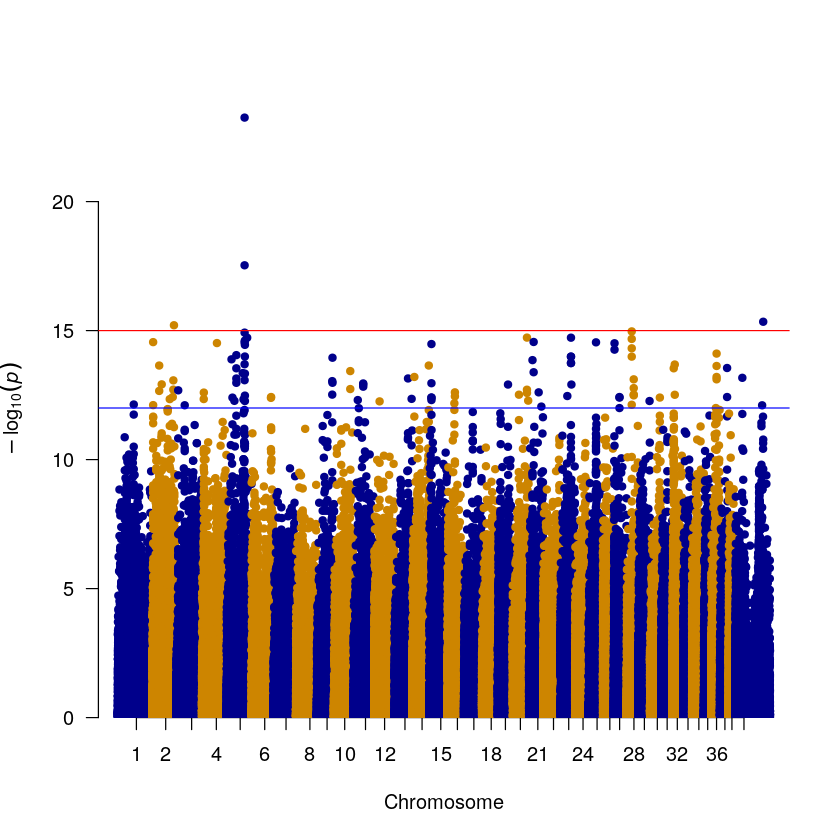

In [6]:
manhattan(data, p = "P", col = c("blue4", "orange3"),
          suggestiveline = 12,
          genomewideline = 15,
          chrlabs = c(1:38, "X"), annotateTop=TRUE, cex = 1.2)

In our graph, haplotypes in four parts of the genome (chromosome 2, 5, 28 and X) are found to be associated with an increased occurrence of the yellow coat color phenotype.

The top associated mutation is a nonsense SNP in the gene MC1R known to control pigment production. The MC1R allele encoding yellow coat color contains a single base change (from C to T) at the 916th nucleotide.